In [320]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

from scipy.ndimage.filters import gaussian_filter1d 
from scipy.signal import find_peaks

from scipy.interpolate import splprep, splev

In [321]:
#Load in JSON Files / File IO

JSON_DATA_PATH = "/Users/sreeharirammohan/Desktop/SCP_FOLDER/video_2/json"
FPS = 29.970
all_json_files = os.listdir(JSON_DATA_PATH)
all_json_files.sort() #order the json files from the first frame to the last. 
del all_json_files[0] #remove .DS_STORE 

In [322]:
#Calculate minimum distance between peaks given STS information and FPS

FIVE_STS = 11.34
FIVE_STS_SD = 2.44
MIN_THRESH = FIVE_STS - 2*FIVE_STS_SD #99% + of patients will be above this value (3 standard deviations to the left of mean)
MIN_THRESH /= 5 # time for 1 STS
MIN_FRAMES = MIN_THRESH * FPS
print(MIN_FRAMES)

38.72124


In [323]:
'''
Downsamples the signal from a given FPS to a different FPS

Precondition: Desired FPS < Current FPS
'''

def downsample(signal, fps_desired, fps_signal):    
    global FPS
    subsampled_signal = []
        
    choose_every_x_frames = int(round(fps_signal/fps_desired))
    
    print("choosing one out of every", choose_every_x_frames, "frames")
    
    for i in range(0, len(signal)):
        if(i%(choose_every_x_frames) == 0):
            subsampled_signal.append(signal[i])
            
    #Redefine FPS since we have changed the frames per second in our signal.
    FPS = fps_desired        
    
    return subsampled_signal

In [324]:
all_json_files = downsample(signal=all_json_files, fps_desired=15, fps_signal=FPS)

choosing one out of every 2 frames


In [325]:
def compute_midpoint(json_file_data, person_number, keypoint1_id, keypoint2_id):
    segment_1_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint1_id]
    segment_1_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    segment_2_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id]
    segment_2_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    return ((segment_1_x + segment_2_x)/2 , (segment_1_y + segment_2_y)/2 )

In [326]:
'''
Calculate Euclidian Distance 2D
'''

def calculate_distance(json_file_data, person_number, keypoint1_id, keypoint2_id):
    
    keypoint1_id = int(keypoint1_id)
    
    keypoint2_id = int(keypoint2_id)
    
    segment_1_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint1_id]
    segment_1_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    segment_1_xy = [segment_1_x, segment_1_y]
    
    segment_2_x = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id]
    segment_2_y = json_file_data["people"][person_number]["pose_keypoints_2d"][3*keypoint2_id + 1]
    
    segment_2_xy = [segment_2_x, segment_2_y]
    
    from scipy.spatial import distance
    
    distance = distance.euclidean(segment_1_xy, segment_2_xy)

    return distance

In [327]:
'''
This method finds the angle between the 8-9 and 9-10 segments. 
'''
def determine_angle_for_json_file(json_file_data, person_number, segment1, segment2):
    
    first_coordinate = int(segment1.split('-')[0])
    
    second_coordinate = int(segment1.split('-')[1])
    
    redundant_second_coordinate = int(segment2.split('-')[0])
    
    third_coordinate = int(segment2.split('-')[1])
    
    if not redundant_second_coordinate == second_coordinate:
        print("ERROR: Two points you find the angle between must be adjacent (share a common vertex)")
        return None
    
    #print(first_coordinate, second_coordinate, third_coordinate)
    
    #No people detected in the scene
    if (len(json_file_data["people"]) == 0):
        return
    
    # 8th segment x, y
    x_8 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*first_coordinate]
    y_8 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*first_coordinate + 1]

    # 9th segment x, y
    x_9 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*second_coordinate]
    y_9 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*second_coordinate + 1]

    #10th
    x_10 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*third_coordinate]
    y_10 = json_file_data["people"][person_number]["pose_keypoints_2d"][3*third_coordinate + 1]
    
    
    if (x_9 == x_8 or x_10 == x_9):
        return 0
    
    slope_8_9 = (y_9 - y_8)/(x_9 - x_8)
    slope_9_10 = (y_10 - y_9)/(x_10 - x_9)
    
    temp_calc = (slope_9_10 - slope_8_9)/(1 + slope_8_9*slope_9_10)
    
    angle_rad = np.arctan(temp_calc)
    
    angle = angle_rad * (180/np.pi)
    
    if(angle < 0):
        angle = -angle
        
    return angle
    

In [328]:
def create_feature_signal_from_video():

    frame_number = 0

    knee_angle = np.array([])
    back_to_mid_knee_dist = np.array([])
    hands_and_toes_dist = np.array([])

    angles = []

    for name in all_json_files:

        filename = os.path.join(JSON_DATA_PATH, name)

        with open(filename, 'r') as j:
            json_file_data = json.load(j)
            angle = determine_angle_for_json_file(json_file_data=json_file_data, person_number=0, segment1="8-9", segment2='9-10')


            knee_1_angle = determine_angle_for_json_file(json_file_data=json_file_data, person_number=0, segment1="8-9", segment2='9-10')
            knee_2_angle = determine_angle_for_json_file(json_file_data=json_file_data, person_number=0, segment1="12-13", segment2='13-14')
            knee_angle = np.append(knee_angle, knee_1_angle + knee_2_angle)

            back_knee_dist_1 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="1", keypoint2_id='10')
            back_knee_dist_2 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="1", keypoint2_id='13')
            back_to_mid_knee_dist = np.append(back_to_mid_knee_dist, back_knee_dist_1 + back_knee_dist_2)

            hands_and_toes_1 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="4", keypoint2_id='23')
            hands_and_toes_2 = calculate_distance(json_file_data=json_file_data, person_number=0, keypoint1_id="7", keypoint2_id='20')
            hands_and_toes_dist = np.append(hands_and_toes_dist, hands_and_toes_1 + hands_and_toes_2)

            angles.append(angle)
            frame_number += 1    

    #Standardize Everything
    knee_angle_scaled = (knee_angle - np.mean(knee_angle)) / np.std(knee_angle)
    back_to_mid_knee_dist_scaled = (back_to_mid_knee_dist - np.mean(back_to_mid_knee_dist)) / np.std(back_to_mid_knee_dist)
    hands_and_toes_dist_scaled = (hands_and_toes_dist - np.mean(hands_and_toes_dist)) / np.std(hands_and_toes_dist)


    signal = knee_angle_scaled + (-0.25 * back_to_mid_knee_dist_scaled) + (-0.75 * hands_and_toes_dist_scaled)

    frame_x = list(range(0, frame_number))
    
    return (frame_x, signal)

In [329]:
def determine_number_of_patient_squats(frame_x, signal):

    y_filter_signal = gaussian_filter1d(signal, 6)
        
    peak_indexes = find_peaks(y_filter_signal, distance=MIN_THRESH*FPS) #Must recalculate the min frames between peaks since we could have resampled our signal

    
    peak_x = []
    peak_y = []

    for peak_index in list(peak_indexes[0]):
        peak_x.append(frame_x[peak_index])
        peak_y.append(y_filter_signal[peak_index])
    
    plt.figure(figsize=(20,5))
    plt.plot(frame_x, y_filter_signal, c='b')
    plt.scatter(peak_x, peak_y, c='r')

    return {'num_squats':len(peak_x), 'peak_indexes':peak_indexes[0], 'peak_x_cords':peak_x}


In [330]:
'''
Determines the regularity of the STS

Essentially standard deviation between squats (peaks)

'''
def compute_regularity(peak_x):    
    time_deltas = np.array([])
    
    for i in range(1, len(peak_x)):
        time_deltas = np.append(time_deltas, abs(peak_x[i-1] - peak_x[i]))
        
    return time_deltas.std()

In [331]:
'''
Computes cosine Similarity of two lists of y data
'''

def compute_cosine_similarity(list_1, list_2):
    from numpy import dot
    from numpy.linalg import norm
    
    cosine_similarity = dot(list_1, list_2)/(norm(list_1)*norm(list_2))
    return cosine_similarity

In [332]:
'''
Computes Spline Interpolation function for a given input of X and Y data 
'''
def interpolate_curve_using_spline(x_input_data, y_input_data):
    from scipy import interpolate    
    
    tck = interpolate.splprep(x_input_data, y_input_data)
    
    xnew = x_input_data
    ynew = interpolate.splev(xnew, tck, der=0)
    
    return ynew #returns the X, Y data of the new points

In [333]:
'''
Returns the mean, median, range, std of similarity for all squats the patient did.

Where values of 1 matches a cubic spline interpolation (showing the squat is very regular)

Where values of 0 are very irregular
'''
def determine_similarity_of_squat(peak_indexes, frame_x, raw_signal):
    
    similarity = np.array([])
    
    for i in range(1, len(peak_indexes)):
        #compare raw squat signal between i and i-1 peak to spline interpolation between same peaks
        
        lower_index = peak_indexes[i-1]
        upper_index = peak_indexes[i]
        
        x_axes = frame_x[lower_index:upper_index]
        
        raw_signal_from_patient = raw_signal[lower_index:upper_index]
        
        #spline interpolation
        tck, u = splprep([frame_x[lower_index:upper_index], raw_signal[lower_index:upper_index]], k=3, s=8)
        spline_interpolated = splev(u, tck)
        
        cos_sim = compute_cosine_similarity(signal[lower_index:upper_index], spline_interpolated[1])
        plt.figure(figsize=(20,5))
        
        #Visualization of spline and raw signal
        plt.plot(spline_interpolated[0], spline_interpolated[1], c='b')
        plt.plot(x_axes, raw_signal[lower_index:upper_index], c='r')

        
        similarity = np.append(similarity, cos_sim)
    
    
    mean_sim = np.mean(similarity)
    median_sim = np.median(similarity)
    range_sim = np.max(similarity) - np.min(similarity)
    std_sim = np.std(similarity)
    
    return {'mean':mean_sim, 'median':median_sim, 'range':range_sim, 'std':std_sim}

In [334]:
(frame_x, signal) = create_feature_signal_from_video()

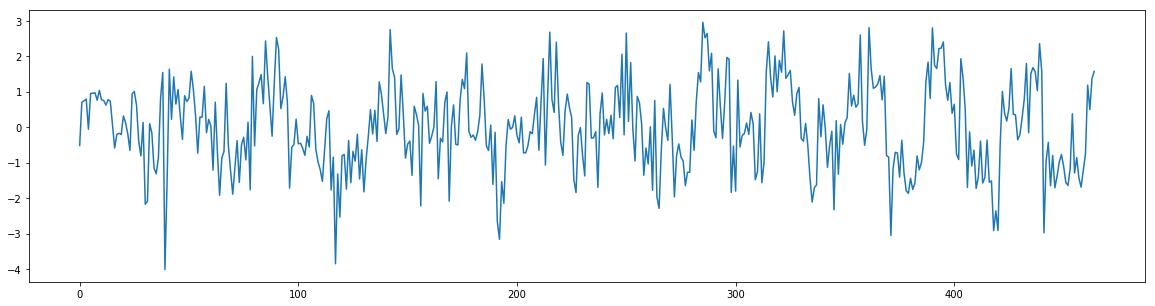

In [335]:
#Let's plot the original signal vs frames
plt.figure(figsize=(20,5))

plt.plot(frame_x, signal)

The patient squatted 12 times


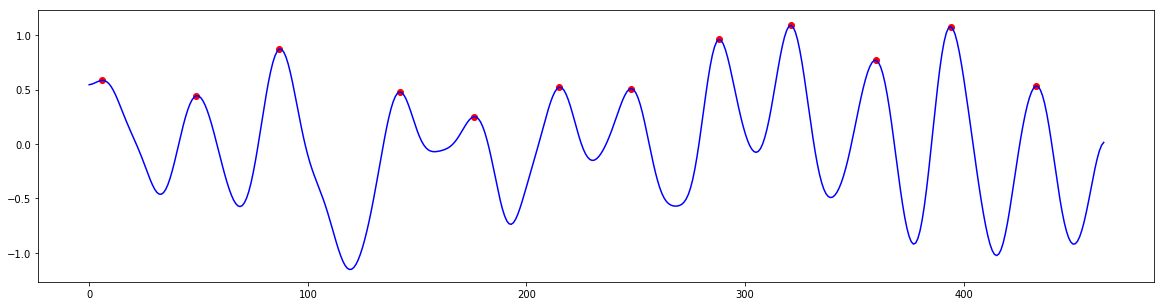

In [336]:
# It is messy now, but don't worry the peak detection uses a Gaussian Filter under the hood to smooth out 
result = determine_number_of_patient_squats(frame_x, signal)

num_squats = result['num_squats']

peak_indexes = result['peak_indexes']

peak_x = result['peak_x_cords']

print("The patient squatted", num_squats, "times")

In [337]:
#Compute regularity 

print("Regularity is", compute_regularity(peak_x))

Regularity is 5.9972445463529604


0.9283986045664782 0.9277221859749046 0.057072060738415864 0.018985903529887497


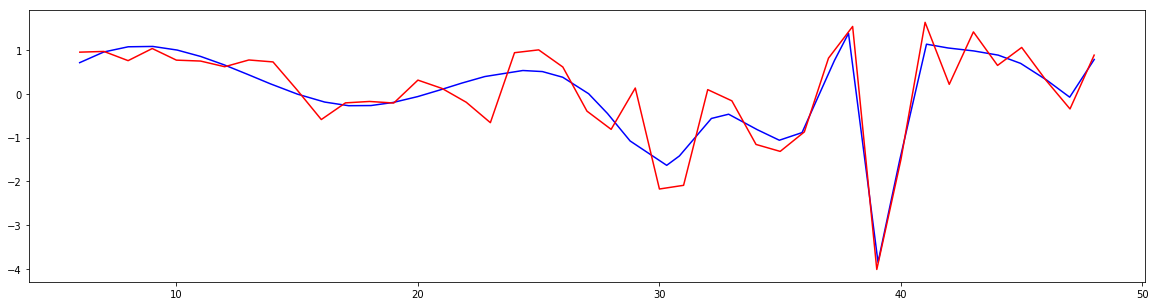

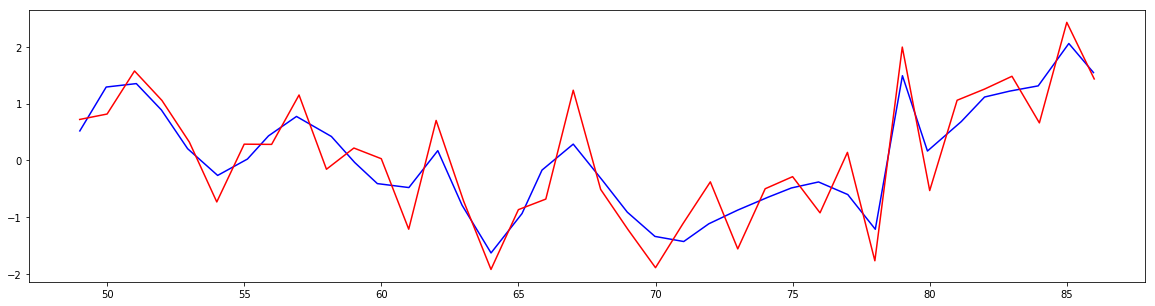

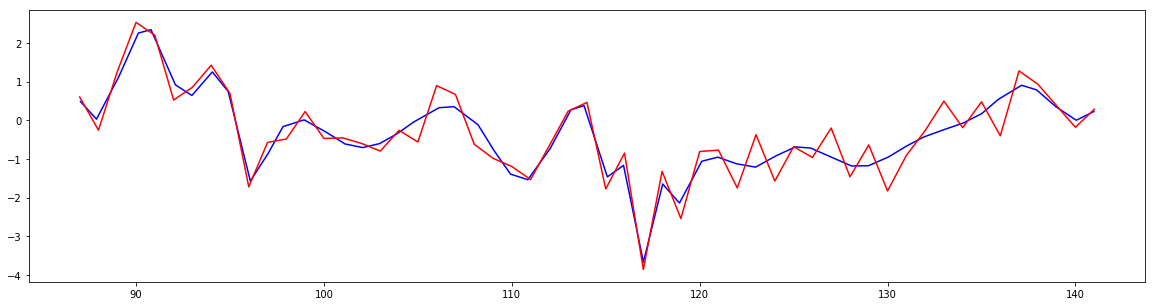

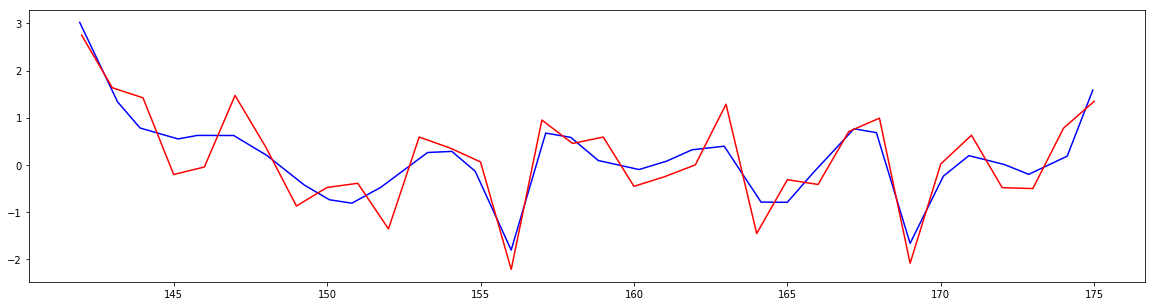

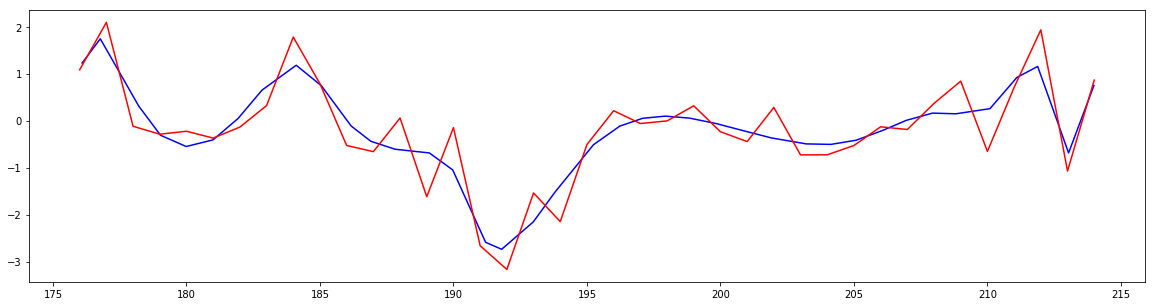

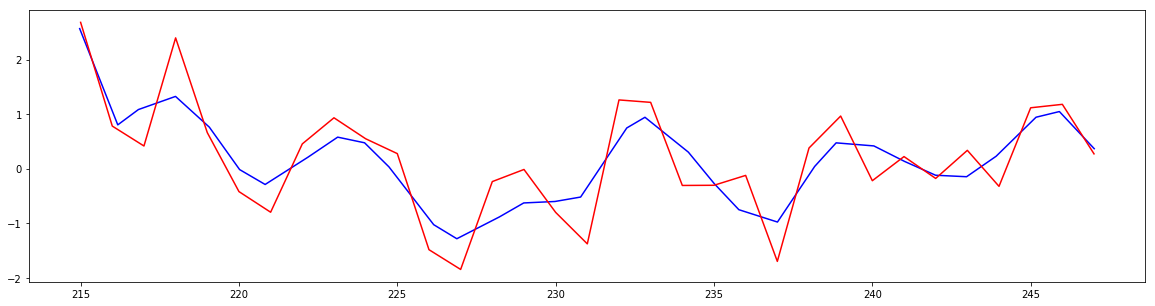

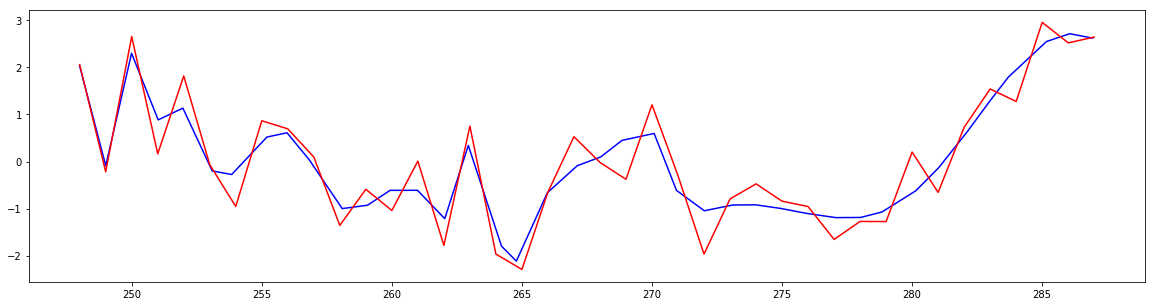

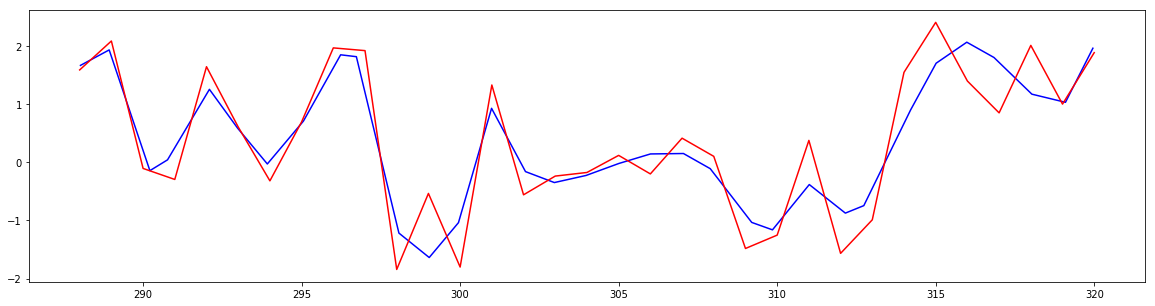

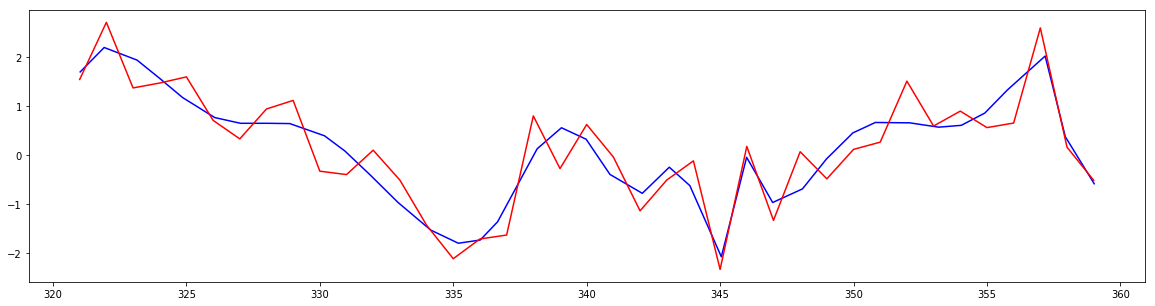

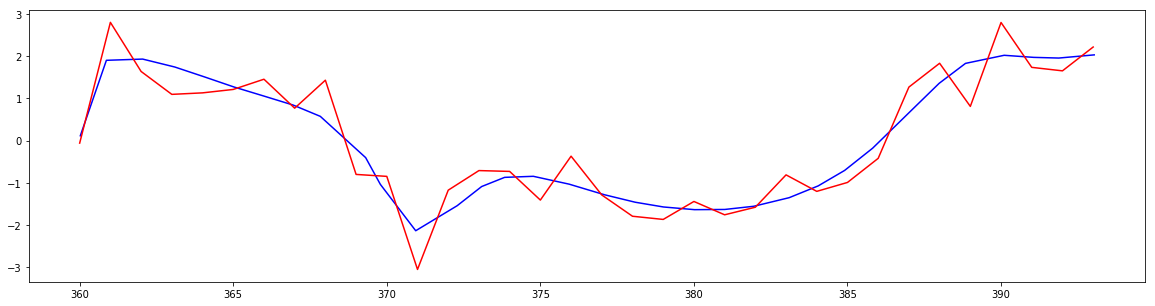

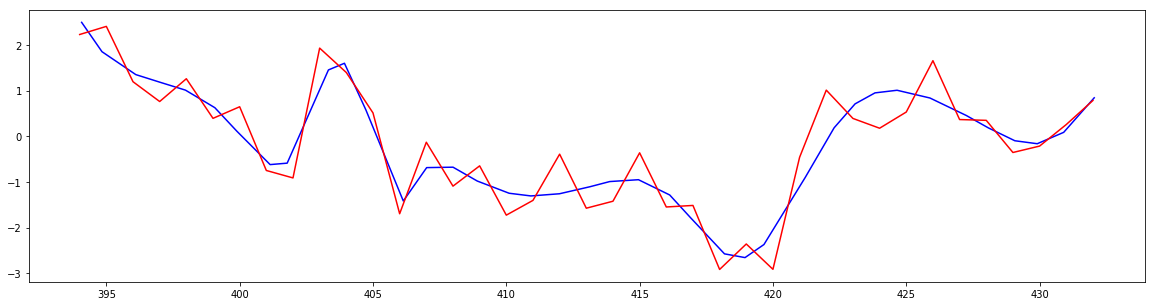

In [338]:
#Determine Similarity of Squat

result_dict = determine_similarity_of_squat(peak_indexes, frame_x, signal)

mean = result_dict['mean']
median = result_dict['median']
_range = result_dict['range']
standard_deviation = result_dict['std']

print(mean, median, _range, standard_deviation)